In [1]:
pip install prophet

     ---------------------------------------- 13.3/13.3 MB 7.9 MB/s eta 0:00:00
     ---------------------------------------- 94.5/94.5 kB 5.3 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pred_vs_actual(index, y_true, y_pred, model_name, start=None, end=None, save_path=None):
    """
    index     : pandas.DatetimeIndex (or array-like) aligned with y_true/y_pred
    y_true    : 1D array-like of actual values
    y_pred    : 1D array-like of predictions (aligned to y_true)
    model_name: label for the title/legend
    start,end : optional slice to zoom (e.g., '2016-05-10', '2016-05-15' or integer slice)
    save_path : optional path to save the PNG
    """
    
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    dfp = pd.DataFrame({"y_true": y_true, "y_pred": y_pred}, index=index)
    if start is not None or end is not None:
        dfp = dfp.loc[start:end]

    plt.figure(figsize=(12,5))
    plt.plot(dfp.index, dfp["y_true"], label="Actual", alpha=0.9)
    plt.plot(dfp.index, dfp["y_pred"], label=model_name, alpha=0.85)
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Energy (Appliances)")
    plt.legend()
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=120, bbox_inches="tight")
    plt.show()

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100)

def log_model_result(model_name, y_true, y_pred, n_params=None, extra=None,
                     csv_path="reports/model_scores.csv"):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(mean_squared_error(y_true, y_pred) ** 0.5)
    mp   = mape(y_true, y_pred)

    row = {"model": model_name, "MAE": mae, "RMSE": rmse, "MAPE": mp,
           "n_params": (int(n_params) if n_params is not None else np.nan)}
    if isinstance(extra, dict):
        row.update(extra)

    p = Path(csv_path)
    p.parent.mkdir(parents=True, exist_ok=True)
    header = not p.exists()
    pd.DataFrame([row]).to_csv(p, mode="a", header=header, index=False)

C:\Users\mirun\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
13:56:34 - cmdstanpy - INFO - Chain [1] start processing
13:56:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mirun\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


MAE: 75.73202467647423
RMSE: 127.04398396857914


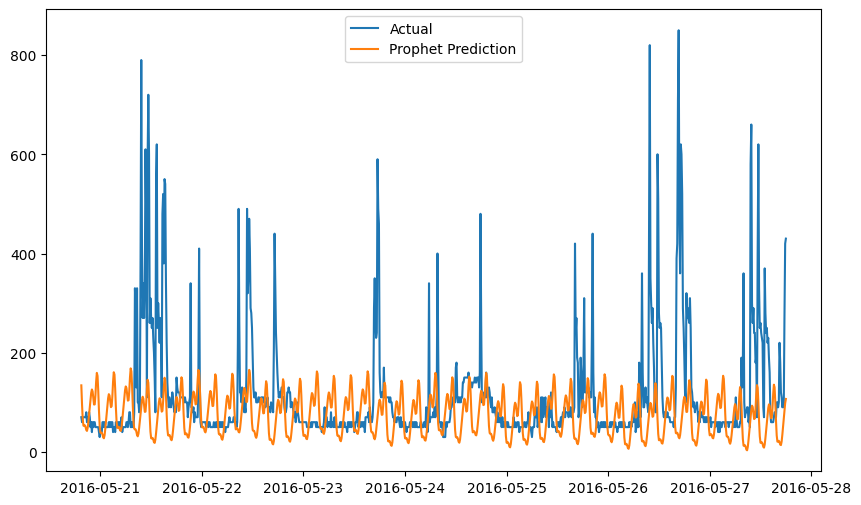

In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/raw/energydata_complete.csv", parse_dates=["date"])
df = df[["date", "Appliances"]]
df.columns = ["ds", "y"]

train = df[:-1000]
test = df[-1000:]

model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq="H")
forecast = model.predict(future)

pred = forecast.tail(len(test))["yhat"].values
mae = mean_absolute_error(test["y"], pred)
rmse = np.sqrt(mean_squared_error(test["y"], pred))

print("MAE:", mae)
print("RMSE:", rmse)

plt.figure(figsize=(10,6))
plt.plot(test["ds"], test["y"], label="Actual")
plt.plot(test["ds"], pred, label="Prophet Prediction")
plt.legend()
plt.show()

13:59:53 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mirun\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


MAE: 70.65936991946883
RMSE: 124.4406496211925


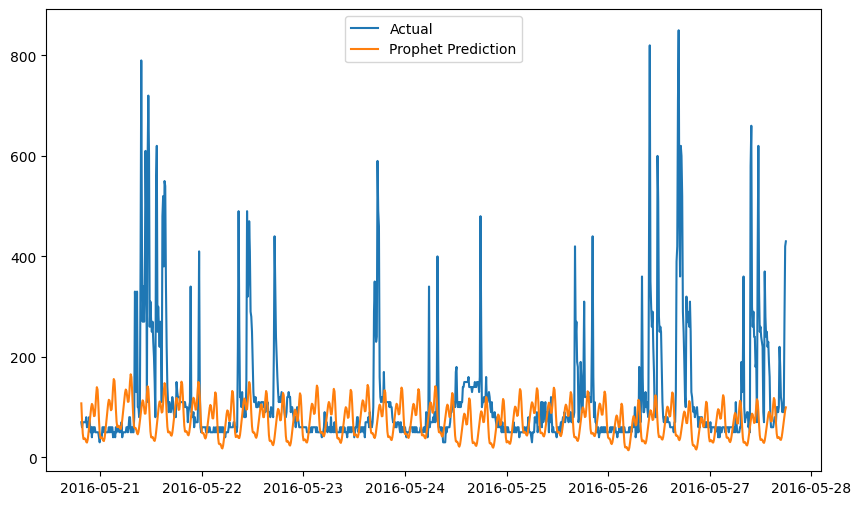

In [2]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/raw/energydata_complete.csv", parse_dates=["date"])
df = df[["date", "Appliances"]]
df.columns = ["ds", "y"]

train = df[:-1000]
test = df[-1000:]

model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.5,
    seasonality_mode='multiplicative'
)

model.add_seasonality(name='hourly', period=24, fourier_order=6)
model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq="H")
forecast = model.predict(future)

pred = forecast.tail(len(test))["yhat"].values
mae = mean_absolute_error(test["y"], pred)
rmse = np.sqrt(mean_squared_error(test["y"], pred))

print("MAE:", mae)
print("RMSE:", rmse)

plt.figure(figsize=(10,6))
plt.plot(test["ds"], test["y"], label="Actual")
plt.plot(test["ds"], pred, label="Prophet Prediction")
plt.legend()
plt.show()


C:\Users\mirun\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
C:\Users\mirun\AppData\Local\Temp\ipykernel_21196\991677900.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index("date").resample("H").mean().ffill().reset_index()
01:27:09 - cmdstanpy - INFO - Chain [1] start processing
01:27:12 - cmdstanpy - INFO - Chain [1] done processing
01:27:13 - cmdstanpy - INFO - Chain [1] start processing
01:27:16 - cmdstanpy - INFO - Chain [1] done processing
01:27:17 - cmdstanpy - INFO - Chain [1] start processing
01:27:20 - cmdstanpy - INFO - Chain [1] done processing
01:27:21 - cmdstanpy - INFO - Chain [1] start processing
01:27:26 - cmdstanpy - INFO - Cha

{'MAE': 74.05978406962677, 'RMSE': np.float64(100.76227386798239), 'best_params': {'cps': 0.5, 'sps': 5.0, 'hf': 18, 'wf': 6}}


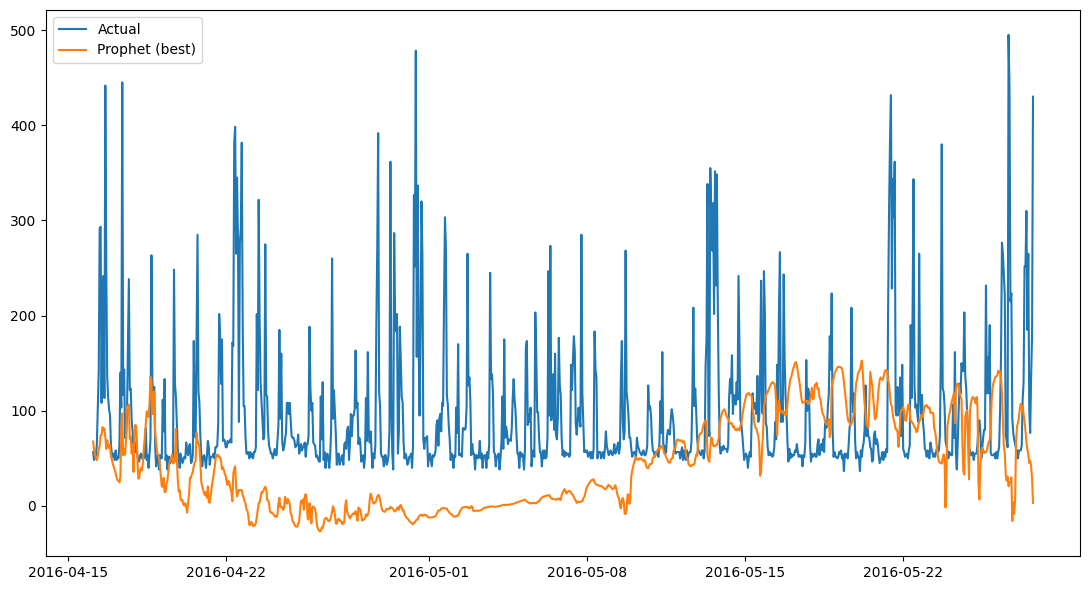

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("data/raw/energydata_complete.csv", parse_dates=["date"])
df = df.set_index("date").resample("H").mean().ffill().reset_index()

cols = ["T_out","RH_out","Windspeed","Visibility","Tdewpoint","lights"]
df = df[["date","Appliances"] + cols]
df.columns = ["ds","y"] + cols

train = df[:-1000].copy()
test  = df[-1000:].copy()

grid = {
    "cps": [0.3, 0.5, 0.8],
    "sps": [5.0, 10.0],
    "hf":  [10, 18],   
    "wf":  [6, 10],         
}

best = None
best_mae = np.inf
best_rmse = np.inf
best_fcst = None

for cps in grid["cps"]:
    for sps in grid["sps"]:
        for hf in grid["hf"]:
            for wf in grid["wf"]:
                m = Prophet(
                    seasonality_mode="multiplicative",
                    changepoint_prior_scale=cps,
                    seasonality_prior_scale=sps,
                    n_changepoints=80,
                    weekly_seasonality=False,
                    daily_seasonality=False
                )
                m.add_seasonality(name="daily",  period=24,    fourier_order=hf)
                m.add_seasonality(name="weekly", period=24*7,  fourier_order=wf)
                for c in cols:
                    m.add_regressor(c)

                m.fit(train[["ds","y"] + cols])

                fut = pd.concat([train[["ds"] + cols], test[["ds"] + cols]], ignore_index=True)
                fc = m.predict(fut)

                yhat = fc.tail(len(test))["yhat"].values
                mae = mean_absolute_error(test["y"].values, yhat)
                rmse = np.sqrt(((test["y"].values - yhat)**2).mean())

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_mae = mae
                    best = (cps, sps, hf, wf, m)
                    best_fcst = yhat

print({"MAE": best_mae, "RMSE": best_rmse, "best_params": {"cps": best[0], "sps": best[1], "hf": best[2], "wf": best[3]}})

plt.figure(figsize=(11,6))
plt.plot(test["ds"], test["y"], label="Actual")
plt.plot(test["ds"], best_fcst, label="Prophet (best)")
plt.legend(); plt.tight_layout(); plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [4]:
y_true = test["y"].values
y_pred = best_fcst

log_model_result(
    model_name="Prophet_hourly_weekly",
    y_true=y_true,
    y_pred=y_pred,
    n_params=None,
)

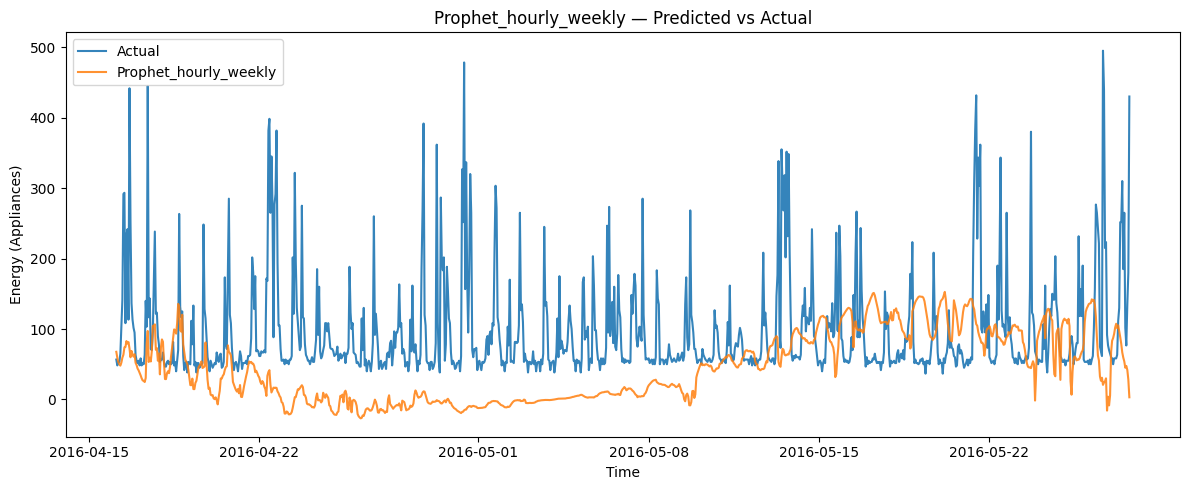

In [6]:
plot_pred_vs_actual(
    index=test["ds"],
    y_true=test["y"],
    y_pred=best_fcst,
    model_name="Prophet_hourly_weekly",
    save_path="reports/figures/prophet_pred_vs_actual.png"
)

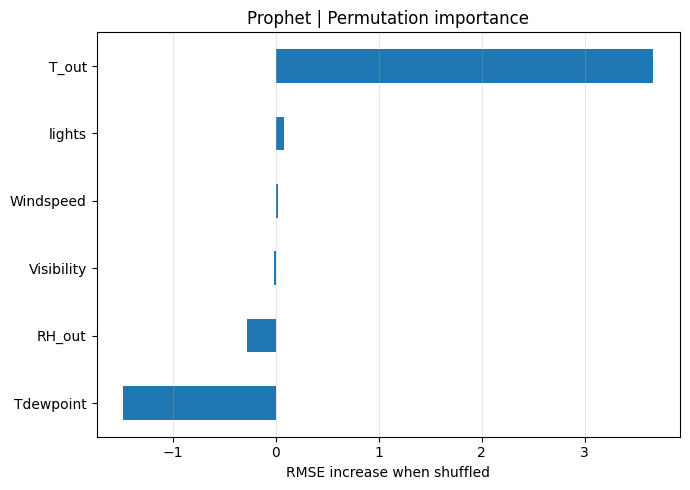

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

m_best = best[4]

fut = pd.concat([train[["ds"] + cols], test[["ds"] + cols]], ignore_index=True)

base_pred = m_best.predict(fut).tail(len(test))["yhat"].to_numpy()
y_true    = test["y"].to_numpy()
rmse_base = rmse(y_true, base_pred)

imp = {}
start = len(train)  
rng = np.random.default_rng(7)

for c in cols:
    fut_perm = fut.copy()
    fut_perm.loc[start:, c] = rng.permutation(fut_perm.loc[start:, c].to_numpy())
    perm_pred = m_best.predict(fut_perm).tail(len(test))["yhat"].to_numpy()
    imp[c] = rmse(y_true, perm_pred) - rmse_base

imp_s = pd.Series(imp).sort_values()
ax = imp_s.plot(kind="barh", figsize=(7,5), title="Prophet | Permutation importance")
ax.set_xlabel("RMSE increase when shuffled")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()
